# Basic Usage of the CERN Injector Model

This notebook demonstrates the basic functionality of the `injector_model` package for calculating bunch intensities across the CERN ion injectors (Linac3 → LEIR → PS → SPS → LHC injection).

## Overview

The `InjectorChain` class simulates the propagation of ion beams through the CERN accelerator complex, accounting for:
- Space charge limitations in each accelerator
- Electron cooling in LEIR (optional)
- Rest gas transmission in PS
- Bunch splitting in PS
- Stripper foil placement (LEIR-PS or PS-SPS)

Let's start with a simple example!

In [16]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from pathlib import Path
from scipy import constants
import sys
import os

# Add the parent directory to Python path to import injector_model
sys.path.append(str(Path.cwd().parent))
from injector_model import InjectorChain

# Set up matplotlib for nice plots
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 14,
})

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 1. Create an InjectorChain Instance

Let's create our first injector chain with default Pb-like parameters:
- 2 bunches in LEIR
- PS splitting factor of 2 (1 bunch → 2 bunches)
- PS-SPS stripping (default)
- No electron cooling

In [3]:
# Create an InjectorChain instance with baseline parameters
injector_chain = InjectorChain(
    LEIR_bunches=2,                      # 2 bunches in LEIR
    PS_splitting=2,                      # Split each bunch into 2 in PS
    LEIR_PS_strip=False,                 # Use PS-SPS stripping (default)
    account_for_LEIR_ecooling=False,     # Don't include electron cooling
    account_for_PS_rest_gas=True         # Include PS rest gas transmission
)

print(f"✓ InjectorChain created with:")
print(f"  - LEIR bunches: {injector_chain.LEIR_bunches}")
print(f"  - PS splitting: {injector_chain.PS_splitting}")
print(f"  - LEIR-PS stripping: {injector_chain.LEIR_PS_strip}")
print(f"  - Electron cooling: {injector_chain.account_for_LEIR_ecooling}")

Initiated ion type: Pb
Q_LEIR = 54.0, Q_PS = 54.0, Q_SPS = 82.0 (fully stripped)
Strip LEIR-PS: False
✓ InjectorChain created with:
  - LEIR bunches: 2
  - PS splitting: 2
  - LEIR-PS stripping: False
  - Electron cooling: False


## 2. Calculate Bunch Intensity for a Single Ion

Let's calculate the bunch intensity for Lead (Pb) ions through the entire chain:

In [13]:
# Calculate bunch intensity for Pb ions
pb_result = injector_chain.calculate_LHC_bunch_intensity()

print("Pb Ion Beam Parameters through the Injector Chain:")
print("=" * 55)
print(f"Ion type: {injector_chain.ion_type}")
print(f"Mass number (A): {injector_chain.A}")
print(f"Atomic number (Z): {injector_chain.Z}")
print(f"\nCharge states:")
print(f"  LEIR: {injector_chain.Q_LEIR}+")
print(f"  PS: {injector_chain.Q_PS}+")
print(f"  SPS: {injector_chain.Q_SPS}+")
print(f"Final LHC bunch intensity:")
print(f"  Ions per bunch: {pb_result['LHC_ionsPerBunch']:.2e}")
print(f"  Charges per bunch: {pb_result['LHC_chargesPerBunch']:.2e}")

Ion type: Pb with Q_PS = 54.0
Account for rest gas in PS transmission: True, assume transmission = 0.92 for cycle length: 1.2 s
SPS gamma0: 7.33600
Pb Ion Beam Parameters through the Injector Chain:
Ion type: Pb
Mass number (A): 208.0
Atomic number (Z): 82.0

Charge states:
  LEIR: 54.0+
  PS: 54.0+
  SPS: 82.0+
Final LHC bunch intensity:
  Ions per bunch: 2.61e+08
  Charges per bunch: 2.14e+10


## 2.5. How the Model Works Internally

Let's peek inside the `calculate_LHC_bunch_intensity` method to understand the physics step-by-step:

In [21]:
# Let's trace through the calculation step-by-step for Pb ions
print("Step-by-step calculation for Pb ions:")
print("=" * 50)

# We need to import Reference_Values to get the reference parameters
from injector_model.parameters_and_helpers import Reference_Values

# Create reference values instance  
ref = Reference_Values(injector_chain.ion_type, injector_chain.Q_PS, 
                      injector_chain.PS_splitting, injector_chain.LEIR_PS_strip, 
                      injector_chain.account_for_PS_rest_gas)

# Step 1: Initial intensity from source
initial_intensity = (injector_chain.linac3_current * injector_chain.linac3_pulseLength) / (injector_chain.Q_LEIR * constants.e)
print(f"1. Linac3 source intensity: {initial_intensity:.2e} ions/pulse")

# Step 2: LEIR space charge limit using Lambda scaling - "Lambda" is the name of the space charge scaling factor
Lambda_LEIR = injector_chain.Lambda(charge=injector_chain.Q_LEIR, 
                                   m=injector_chain.mass_GeV,
                                   gamma=injector_chain.LEIR_gamma_inj,
                                   charge_0=ref.Q0_LEIR,
                                   m_0=ref.m0_GeV,
                                   gamma_0=ref.gamma0_LEIR_inj)
leir_sc_limit = ref.Nb0_LEIR_inj * Lambda_LEIR
total_leir_intensity = initial_intensity * injector_chain.nPulsesLEIR * ref.LEIR_injection_efficiency
leir_extracted = ref.LEIR_transmission * min(total_leir_intensity, leir_sc_limit) / injector_chain.LEIR_bunches

print(f"2. LEIR space charge limit: {leir_sc_limit:.2e} ions total")
print(f"   → LEIR total injected: {total_leir_intensity:.2e} ions")
print(f"   → LEIR extracted per bunch: {leir_extracted:.2e} ions/bunch")

# Step 3: PS injection (with stripping if LEIR-PS)
ps_injected = leir_extracted * (injector_chain.LEIR_PS_stripping_efficiency if injector_chain.LEIR_PS_strip else ref.LEIR_PS_Transmission)
print(f"3. PS injection intensity: {ps_injected:.2e} ions/bunch")

# Step 4: PS rest gas transmission and splitting
ps_transmitted = ps_injected * ref.PS_transmission / injector_chain.PS_splitting
print(f"4. PS transmission ({ref.PS_transmission:.3f}) + splitting (÷{injector_chain.PS_splitting}): {ps_transmitted:.2e} ions/bunch")

# Step 5: SPS injection (with stripping if PS-SPS)  
sps_injected = ps_transmitted * (ref.PS_SPS_transmission_efficiency if injector_chain.LEIR_PS_strip else ref.PS_SPS_stripping_efficiency)
print(f"5. SPS injection (with stripping): {sps_injected:.2e} ions/bunch")

# Step 6: SPS space charge limit
Lambda_SPS = injector_chain.Lambda(charge=injector_chain.Q_SPS,
                                  m=injector_chain.mass_GeV,
                                  gamma=injector_chain.SPS_gamma_inj,
                                  charge_0=ref.Q0_SPS,
                                  m_0=ref.m0_GeV,
                                  gamma_0=ref.gamma0_SPS_inj)
sps_sc_limit = ref.Nb0_SPS_inj * Lambda_SPS
sps_limited = min(sps_sc_limit, sps_injected)
final_lhc = sps_limited * ref.SPS_transmission * ref.SPS_to_LHC_transmission

print(f"6. SPS space charge limit: {sps_sc_limit:.2e} ions/bunch")
print(f"   → SPS limited intensity: {sps_limited:.2e} ions/bunch")
print(f"   → Final LHC intensity: {final_lhc:.2e} ions/bunch")

# Step 7: Physics insights
print(f"\nCharge state evolution: LEIR: {injector_chain.Q_LEIR}+ → PS: {injector_chain.Q_PS}+ → SPS: {injector_chain.Q_SPS}+")
print(f"Space charge scaling: Λ = (m/m₀)×(Q₀/Q)²×[γ(γ²-1)]/[γ₀(γ₀²-1)]")

# Identify limiting factor
if total_leir_intensity > leir_sc_limit:
    limiting_factor = "LEIR space charge"
elif sps_injected > sps_sc_limit:
    limiting_factor = "SPS space charge"
else:
    limiting_factor = "Source intensity"
print(f"Primary limiting factor: {limiting_factor}")

# Verify our manual calculation matches the method
final_charges = final_lhc * injector_chain.Z
print(f"\n✓ Manual calculation: {final_lhc:.2e} ions/bunch, {final_charges:.2e} charges/bunch")
print(f"✓ Method result: {pb_result['LHC_ionsPerBunch']:.2e} ions/bunch, {pb_result['LHC_chargesPerBunch']:.2e} charges/bunch")

Step-by-step calculation for Pb ions:
Ion type: Pb with Q_PS = 54.0
Account for rest gas in PS transmission: True, assume transmission = 0.92 for cycle length: 1.2 s
1. Linac3 source intensity: 1.04e+09 ions/pulse
2. LEIR space charge limit: 2.58e+09 ions total
   → LEIR total injected: 4.16e+09 ions
   → LEIR extracted per bunch: 9.81e+08 ions/bunch
3. PS injection intensity: 9.13e+08 ions/bunch
4. PS transmission (0.920) + splitting (÷2): 4.20e+08 ions/bunch
5. SPS injection (with stripping): 3.90e+08 ions/bunch
6. SPS space charge limit: 3.90e+08 ions/bunch
   → SPS limited intensity: 3.90e+08 ions/bunch
   → Final LHC intensity: 2.61e+08 ions/bunch

Charge state evolution: LEIR: 54.0+ → PS: 54.0+ → SPS: 82.0+
Space charge scaling: Λ = (m/m₀)×(Q₀/Q)²×[γ(γ²-1)]/[γ₀(γ₀²-1)]
Primary limiting factor: LEIR space charge

✓ Manual calculation: 2.61e+08 ions/bunch, 2.14e+10 charges/bunch
✓ Method result: 2.61e+08 ions/bunch, 2.14e+10 charges/bunch


## 3. Calculate for All Ion Species

Now let's calculate bunch intensities for all ion species in our database:

In [6]:
# Calculate LHC bunch intensities for all ion species
df_all_ions = injector_chain.calculate_LHC_bunch_intensity_all_ion_species(
    save_csv=False  # Don't save CSV for this example
)

print(f"Calculated intensities for {len(df_all_ions)} ion species:")
print("\nIon species in database:")
for ion in df_all_ions.index:
    print(f"  - {ion}")

# Display first few columns of results
print("\nSample results (first 5 columns):")
display_cols = ['massNumber', 'atomicNumber', 'Q_LEIR', 'LHC_ionsPerBunch', 'LHC_chargesPerBunch']
print(df_all_ions[display_cols].round(2))

Initiated ion type: He
Q_LEIR = 1.0, Q_PS = 1.0, Q_SPS = 2.0 (fully stripped)
Strip LEIR-PS: False
Ion type: He with Q_PS = 1.0
Account for rest gas in PS transmission: True, assume transmission = 0.7639097491244964 for cycle length: 1.2 s
SPS gamma0: 7.33600
Initiated ion type: O
Q_LEIR = 4.0, Q_PS = 4.0, Q_SPS = 8.0 (fully stripped)
Strip LEIR-PS: False
Ion type: O with Q_PS = 4.0
Account for rest gas in PS transmission: True, assume transmission = 0.7269397232357733 for cycle length: 1.2 s
SPS gamma0: 7.33600
Initiated ion type: Mg
Q_LEIR = 7.0, Q_PS = 7.0, Q_SPS = 12.0 (fully stripped)
Strip LEIR-PS: False
Ion type: Mg with Q_PS = 7.0
Account for rest gas in PS transmission: True, assume transmission = 0.8231856075975958 for cycle length: 1.2 s
SPS gamma0: 7.33600
Initiated ion type: Ar
Q_LEIR = 11.0, Q_PS = 11.0, Q_SPS = 18.0 (fully stripped)
Strip LEIR-PS: False
Ion type: Ar with Q_PS = 11.0
Account for rest gas in PS transmission: True, assume transmission = 0.8808624324067938 f

## 4. Visualize Results

Let's create some plots to visualize the bunch intensities:

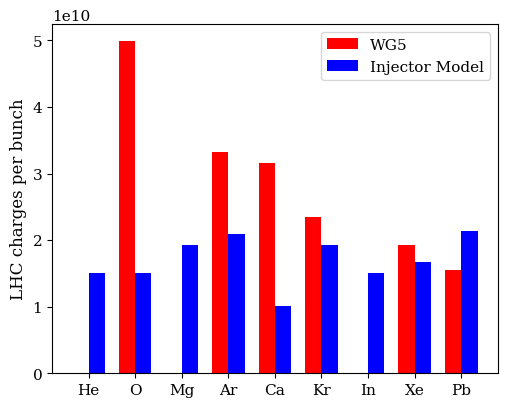

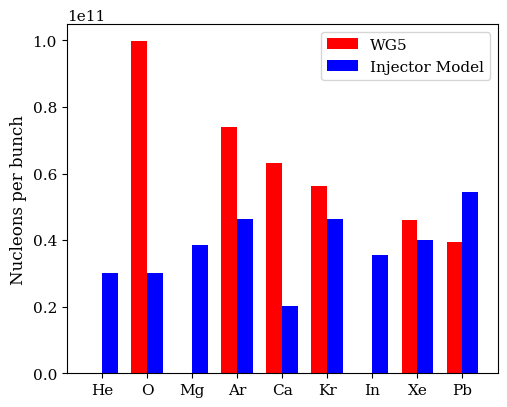

Comparison plots created successfully!
Red bars: WG5 reference values
Blue bars: Injector Model predictions


In [9]:
# Create visualization of LHC bunch intensities
# Load reference data for comparison
data_folder = Path.cwd().parent / 'data'
ref_Table_SPS = pd.read_csv(data_folder / 'test_and_benchmark_data' / 'SPS_final_intensities_WG5_and_Hannes.csv', index_col=0)

# Set up plotting parameters like in your calculation script
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 13
plt.rcParams["font.family"] = "serif"
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)

# Define bar width for bar plot
bar_width = 0.35
x = np.arange(len(df_all_ions.index))

# Plot 1: LHC charges per bunch comparison
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
bar1 = ax.bar(x - bar_width/2, ref_Table_SPS['WG5 Intensity']*df_all_ions['atomicNumber'], 
              bar_width, color='red', label='WG5')
bar2 = ax.bar(x + bar_width/2, df_all_ions['LHC_chargesPerBunch'], 
              bar_width, color='blue', label='Injector Model')
ax.set_xticks(x)
ax.set_xticklabels(df_all_ions.index)
ax.set_ylabel("LHC charges per bunch")
ax.legend()
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

# Plot 2: Nucleons per bunch comparison  
fig2, ax2 = plt.subplots(1, 1, figsize=(5, 4))
bar21 = ax2.bar(x - bar_width/2, ref_Table_SPS['WG5 Intensity']*df_all_ions['massNumber'], 
                bar_width, color='red', label='WG5')
bar22 = ax2.bar(x + bar_width/2, df_all_ions['LHC_ionsPerBunch']*df_all_ions['massNumber'], 
                bar_width, color='blue', label='Injector Model')
ax2.set_xticks(x)
ax2.set_xticklabels(df_all_ions.index)
ax2.set_ylabel("Nucleons per bunch")
ax2.legend()
fig2.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

print("Comparison plots created successfully!")
print("Red bars: WG5 reference values")
print("Blue bars: Injector Model predictions")

## 5. Understanding the Limitations

Let's examine what limits the beam intensity in each accelerator:

In [12]:
# Analyze limiting factors
print("Space Charge Limits vs Maximum Intensities:")
print("=" * 45)

for ion in df_all_ions.index:
    row = df_all_ions.loc[ion]
    print(f"\n{ion}:")
    
    # Check LEIR limitation
    leir_limited = row['LEIR_maxIntensity'] <= row['LEIR_space_charge_limit']
    print(f"  LEIR: {'Not SC limited' if leir_limited else 'SC limited'} "
          f"(Nb_max = {row['LEIR_maxIntensity']:.1e} vs SC limit = {row['LEIR_space_charge_limit']:.1e})")
    
    # Check SPS limitation  
    sps_limited = row['SPS_maxIntensity'] <= row['SPS_space_charge_limit']
    print(f"  SPS:  {'Not SC limited' if sps_limited else 'SC limited'} "
          f"(Nb_max = {row['SPS_maxIntensity']:.1e} vs SC limit = {row['SPS_space_charge_limit']:.1e})")

Space Charge Limits vs Maximum Intensities:

He:
  LEIR: SC limited (Nb_max = 1.2e+12 vs SC limit = 1.4e+11)
  SPS:  SC limited (Nb_max = 1.8e+10 vs SC limit = 1.1e+10)

O:
  LEIR: SC limited (Nb_max = 1.7e+11 vs SC limit = 3.6e+10)
  SPS:  SC limited (Nb_max = 4.3e+09 vs SC limit = 2.8e+09)

Mg:
  LEIR: SC limited (Nb_max = 2.1e+10 vs SC limit = 1.8e+10)
  SPS:  Not SC limited (Nb_max = 2.4e+09 vs SC limit = 3.0e+09)

Ar:
  LEIR: SC limited (Nb_max = 4.1e+10 vs SC limit = 1.2e+10)
  SPS:  Not SC limited (Nb_max = 1.7e+09 vs SC limit = 1.9e+09)

Ca:
  LEIR: SC limited (Nb_max = 1.1e+10 vs SC limit = 5.0e+09)
  SPS:  Not SC limited (Nb_max = 7.6e+08 vs SC limit = 5.5e+09)

Kr:
  LEIR: SC limited (Nb_max = 1.4e+10 vs SC limit = 6.4e+09)
  SPS:  SC limited (Nb_max = 9.6e+08 vs SC limit = 8.0e+08)

In:
  LEIR: SC limited (Nb_max = 5.1e+09 vs SC limit = 3.0e+09)
  SPS:  Not SC limited (Nb_max = 4.6e+08 vs SC limit = 1.1e+09)

Xe:
  LEIR: SC limited (Nb_max = 5.8e+09 vs SC limit = 3.1e+09)
 

## 6. Summary

This example demonstrated:

1. **Basic setup**: Creating an `InjectorChain` instance with specific parameters
2. **Single ion calculation**: Getting detailed results for one ion species (Pb)
3. **Multi-ion analysis**: Calculating intensities for all ions in the database
4. **Visualization**: Creating plots to compare bunch intensities
5. **Limitation analysis**: Understanding what limits beam intensity in each accelerator

The model accounts for realistic physics limitations including space charge effects, which are particularly important for high-intensity ion beams. The results show that different ion species achieve different maximum intensities depending on their charge-to-mass ratios and the specific charge states used in each accelerator.

## Next Steps

Try the other example notebooks to explore:
- **02_electron_cooling_effects.ipynb**: Impact of LEIR electron cooling
- **03_bunch_splitting_scenarios.ipynb**: Different PS splitting strategies
- **04_stripper_foil_comparison.ipynb**: LEIR-PS vs PS-SPS stripping
- **05_advanced_scenarios.ipynb**: Combined parameter studies and optimization